# Feature Selection and Dummifying
---

## Imports and Functions
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
def qual_to_num(data, feature):
    '''
    Takes in DataFrame and column name containing string ratings
    replaces the ratings with numerical values
    
    Returns the updated DataFrame
    '''
    
    # ratings that appear in the dataset
    # and corresponding numerical value
    qual_conversion = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0, np.nan: 0}
    
    # convert to ratings using dictionary
    data[feature] = data[feature].apply(lambda x: qual_conversion[x])
    
    return data



def vif_df(df):
    '''
    Takes in a dataframe of numeric columns and computes
    the Variance Inflation Factor (VIF) for each variable.
    
    Returns a nx1 DataFrame of VIF scores.
    '''
    
    corr_features = df.columns
    
    # creats a list of VIF values, cycling through variables
    # to select as a target for scoring
    vif_values = [variance_inflation_factor(df.values, i) for i in range(len(corr_features))]
    
    # index scores with column names and sort from greatest to least
    vif = pd.DataFrame(vif_values,
                   index = corr_features,
                   columns = ['vif']).sort_values(by = 'vif', ascending = False)
    
    return vif



def setup_test():
    '''
    Generates a cleaned and feature engineered test dataset
    that matches the general structure of the cleaned train data.
    
    Returns the cleaned, feature engineered test data set.
    '''
    
    test_data = pd.read_csv('../datasets/test.csv')
    
    # initial features that were selected for the train dataset 
    test_features = ['MS Zoning', 'Lot Area', 'Land Contour', 'Land Slope', 'Neighborhood', 'Condition 1',
            'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
           'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
           'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Kitchen Qual', 'Bedroom AbvGr',
           'Full Bath', 'Half Bath', 'Fireplaces', 'Fireplace Qu', 'BsmtFin SF 1', 'Bsmt Unf SF', '1st Flr SF', '2nd Flr SF', 'Sale Type',]
    
    
    test_data = test_data[test_features]
    
    # clean column names
    test_data.columns = [col.lower().replace(' ','_').replace('/','_') for col in test_data.columns]
    
    
    # converts descriptive rating to numerical
    test_data = qual_to_num(test_data, 'bsmt_qual')
    test_data = qual_to_num(test_data, 'bsmt_cond')
    test_data = qual_to_num(test_data, 'kitchen_qual')
    test_data = qual_to_num(test_data, 'exter_qual')
    test_data = qual_to_num(test_data, 'exter_cond')
    test_data = qual_to_num(test_data, 'fireplace_qu')
    
    # combines basment quality and condition ratings via multiplication
    test_data['bsmt_qual_cond'] = test_data['bsmt_qual'] * test_data['bsmt_cond']
    test_data.drop(columns = ['bsmt_qual', 'bsmt_cond'], inplace = True)
    
    test_data['qual_cond'] = test_data['overall_qual'] * test_data['overall_cond']
    test_data.drop(columns = ['overall_qual', 'overall_cond'], inplace = True)

    test_data['exter_qual_cond'] = test_data['exter_qual'] * test_data['exter_cond']
    test_data.drop(columns = ['exter_qual', 'exter_cond'], inplace = True)

    
    # combines fireplace count and quality rating via multiplication
    test_data['fireplaces_weighted'] = test_data['fireplaces'] * test_data['fireplace_qu']
    test_data.drop(columns = ['fireplaces', 'fireplace_qu'], inplace = True)
    
    # adds square feet (SF) measurements with weights:
    # 1*(Finished SF) + 0.5(Unfinished SF)
    test_data['bsmt_weighted_sf'] = test_data['bsmtfin_sf_1'] + 0.5*test_data['bsmt_unf_sf']
    test_data.drop(columns = ['bsmtfin_sf_1', 'bsmt_unf_sf'], inplace = True)
    
    # combines full bath and half bath into one column
    test_data['bath'] = test_data['full_bath'] + 0.5*test_data['half_bath']
    test_data.drop(columns = ['full_bath', 'half_bath'], inplace = True)
    
    #combines 1st floor and 2nd floor square feet areas
    test_data['sq_ft'] = test_data['1st_flr_sf'] + test_data['2nd_flr_sf']
    test_data.drop(columns = ['1st_flr_sf', '2nd_flr_sf'], inplace = True)
    
    # replace np.nan with most frequent value in the column 'None'
    test_data.loc[test_data['mas_vnr_type'].isna(), 'mas_vnr_type'] = 'None'
    
    return test_data

## Determining Numeric Features
---

Let us begin by determining which numeric values are most relevant to `saleprice` and are not very correlated to one another.

In [3]:
house = pd.read_csv('../datasets/cleaned_train.csv')

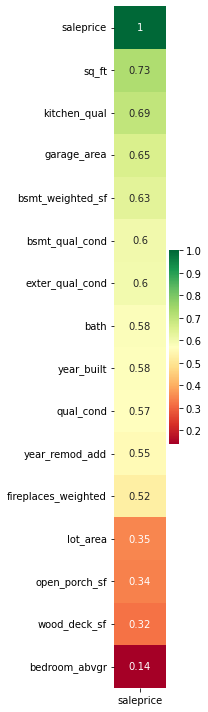

In [4]:
plt.figure(figsize = (3, 10))
corr = house.corr()[['saleprice']].sort_values(by = 'saleprice', ascending = False)
sns.heatmap(corr, cmap = 'RdYlGn', annot = True)
plt.tight_layout()
plt.savefig('../images/saleprice_heatmap.png');

Out of the numeric features we have selected/created, three stand out as correlated to `saleprice`: `sq_ft`, `kitchen_qual`, and `garage_area`. To see these more explicitly, let us check their scatterplots.

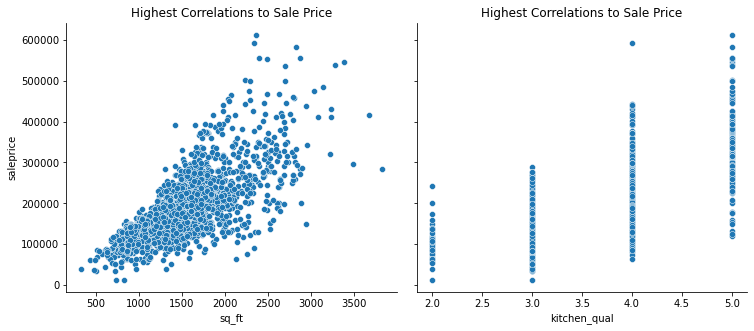

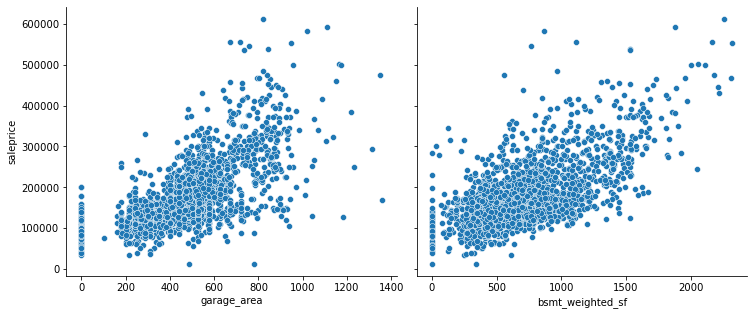

In [5]:
pair1 = sns.pairplot(house, x_vars = ['sq_ft', 'kitchen_qual'], y_vars = ['saleprice'])
pair1.fig.set_size_inches(12,5)
pair1.set(title = 'Highest Correlations to Sale Price')
pair2 = sns.pairplot(house, x_vars = ['garage_area', 'bsmt_weighted_sf'], y_vars = ['saleprice'])
pair2.fig.set_size_inches(12,5)

It would be nice if we could use all of these features in our model, unfortunately, together their variance inflation factors are quite large.

In [6]:
vif_df(house[['sq_ft', 'kitchen_qual', 'garage_area']])

,vif
kitchen_qual,15.163938
sq_ft,14.516739
garage_area,8.499569


In [7]:
vif_df(house[['sq_ft', 'kitchen_qual']])

,vif
sq_ft,12.91426
kitchen_qual,12.91426


In [8]:
vif_df(house[['sq_ft', 'garage_area']])

,vif
sq_ft,7.238598
garage_area,7.238598


In [9]:
vif_df(house[['kitchen_qual', 'garage_area']])

,vif
garage_area,7.561316
kitchen_qual,7.561316


Because each possible pair of the three features produce large VIF scores, we can only use one of these features. Let us use `sq_ft` since it has the highest correlation with `saleprice`.

To determine other features to use, let us again compute pairwise VIF scores with the `sq_ft` column we already plan on incorporating into our model.

In [10]:
numeric_cols = house.select_dtypes(include = 'number').columns

In [11]:
for col in numeric_cols:
    #we have already checked the VIF scores of sq_ft and these three columns
    if col not in ['sq_ft', 'kitche_qual', 'garage_area']:
        print(vif_df(house[['sq_ft', col]]))

               vif
sq_ft     4.942785
lot_area  4.942785
                  vif
sq_ft       10.839815
year_built  10.839815
                      vif
sq_ft           10.804353
year_remod_add  10.804353
                   vif
sq_ft         1.684749
wood_deck_sf  1.684749
                   vif
sq_ft          1.67531
open_porch_sf  1.67531
                   vif
sq_ft         12.91426
kitchen_qual  12.91426
                     vif
sq_ft          12.399268
bedroom_abvgr  12.399268
                 vif
sq_ft      13.298271
saleprice  13.298271
                 vif
sq_ft      10.190095
qual_cond  10.190095
                     vif
sq_ft            11.3611
exter_qual_cond  11.3611
                    vif
sq_ft           8.87909
bsmt_qual_cond  8.87909
                          vif
sq_ft                2.237173
fireplaces_weighted  2.237173
                       vif
sq_ft             4.762963
bsmt_weighted_sf  4.762963
             vif
sq_ft  16.996283
bath   16.996283


A heuristic for selecting features based on VIF scores is to pick ones with scores below 5. The only features satisfying this condition with the `sq_ft` column are:

- `wood_deck_sf`
- `open_porch_sf`
- `fireplaces_weighted`
- `bsmt_weighted_sf`

Although wood decks and open porches surely add value to properties, I highly doubt they are the strongest indicators for home price. Moreover, many homes simply do not have these (47.5% own a wood deck and 55.3% own an open porch). **These may be worth including in a Ridge or Lasso regression** since they may add as much noise as predicting value, something Ridge and Lasso are meant to deal with.

In [12]:
print( (house['wood_deck_sf'] != 0).sum()/len(house) )
print( (house['open_porch_sf'] != 0).sum()/len(house) )

0.474559686888454
0.5543052837573386


Of the two left, `bsmt_weighted_sf` has a stronger correlation to `saleprice`. It produces a little higher VIF than I would like to have since I am still looking to add more columns, but our primary goal is prediction instead of inference, so slightly high VIF is not too problematic. If we consider all three columns `sq_ft`, `bsmt_weighted_sf`, and `fireplaces_weighted`, the VIF scores are a little higher than I would like. Again, this may be worth considering in a later modeling attempt and/or when using Ridge or Lasso.

In [13]:
# may even be worth including all 3
vif_df(house[['sq_ft', 'bsmt_weighted_sf', 'fireplaces_weighted']])

,vif
sq_ft,5.436471
bsmt_weighted_sf,4.880940
fireplaces_weighted,2.292587


Let us store our chosen numeric features for our first model in a list labeled `numeric_features`.

In [14]:
# our choice of numeric features
numeric_features = ['sq_ft', 'bsmt_weighted_sf']

---

## Determining Which Categorical Features to Use

To select which categorical columns we would like to use

In [15]:
categoric_cols = house.select_dtypes(include = ['object'])

In [16]:
categoric_cols.head()

,ms_zoning,land_contour,land_slope,neighborhood,condition_1,bldg_type,house_style,mas_vnr_type,sale_type
0,RL,Lvl,Gtl,Sawyer,RRAe,1Fam,2Story,BrkFace,WD
1,RL,Lvl,Gtl,SawyerW,Norm,1Fam,2Story,BrkFace,WD
2,RL,Lvl,Gtl,NAmes,Norm,1Fam,1Story,None,WD
3,RL,Lvl,Gtl,Timber,Norm,1Fam,2Story,None,WD
4,RL,Lvl,Gtl,SawyerW,Norm,1Fam,1.5Fin,None,WD


In [17]:
for col in categoric_cols.columns:
    print(categoric_cols[col].value_counts(dropna = False))

RL         1591
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: ms_zoning, dtype: int64
Lvl    1842
HLS      85
Bnk      78
Low      39
Name: land_contour, dtype: int64
Gtl    1949
Mod      87
Sev       8
Name: land_slope, dtype: int64
NAmes      310
CollgCr    180
OldTown    163
Edwards    141
Somerst    130
NridgHt    122
Gilbert    116
Sawyer     111
NWAmes      87
SawyerW     87
Mitchel     81
BrkSide     76
Crawfor     71
IDOTRR      69
Timber      48
NoRidge     47
StoneBr     38
SWISU       32
ClearCr     25
MeadowV     24
Blmngtn     22
BrDale      19
NPkVill     17
Veenker     16
Blueste      6
Greens       3
GrnHill      2
Landmrk      1
Name: neighborhood, dtype: int64
Norm      1761
Feedr      108
Artery      70
RRAn        36
PosN        27
RRAe        21
PosA        12
RRNn         6
RRNe         3
Name: condition_1, dtype: int64
1Fam      1693
TwnhsE     161
Duplex      75
Twnhs       69
2fmCon      46
Name: bldg_type

We saw earlier that despite wanting to include many numeric columns, most of them were fairly correlated to `sq_ft`, our primary column of interest, and we could only clearly use two. In the same spirit of avoiding multicollinearity when we chose our numeric variables, let us be picky about which categorical features we decide to use in our model.

Immediately, `neighborhood` stands out as an indicator of property value. It is a diverse column and is not surprising that it produces some separation in the `saleprice` values.

In [18]:
house.groupby('neighborhood')[['saleprice']].mean()

,saleprice
neighborhood,
Blmngtn,200417.681818
Blueste,144566.666667
BrDale,103371.052632
BrkSide,127022.697368
ClearCr,211729.280000
CollgCr,202497.216667
Crawfor,205901.211268
Edwards,129905.787234
Gilbert,189228.387931


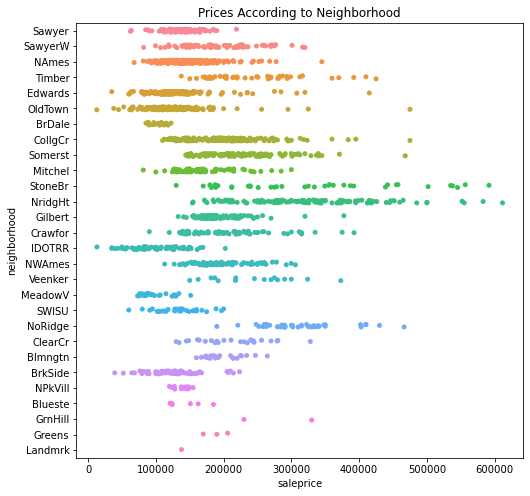

In [19]:
plt.figure(figsize = (8,8))
sns.stripplot(x = 'saleprice', y = 'neighborhood', data = house, jitter = True).set(title = 'Prices According to Neighborhood' ,);

Almost all the other categorical variables have more than 1500 appearances of a single category (out of 2051). This leads me to believe these features will not do a great job at separating out the values of the different homes. Besides the `neighborhood` column, only `house_style` and `mas_vnr_type` have significant spread of values.

Let us start with `neighborhood` and `house_style` as categorical features in our first model. We will include `mas_vnr_type` in a later model.

In [20]:
house.groupby('mas_vnr_type')[['saleprice']].mean()

,saleprice
mas_vnr_type,
BrkCmn,133475.333333
BrkFace,211569.483307
None,154908.626010
Stone,264595.272727


Below, we store the categorical features we have selected for our first model as `categ_features`.

In [21]:
categ_features = ['neighborhood', 'house_style']

---

## Making Sure Dummy Columns Agree Between Train and Test

To create a model involving categorical data we will need to dummify our columns. Unfortunately, it is not guarantee that the dummy columns made from our train data will be the same as the dummy columns that are created from our test data (some category may not appear and thus no column will be created). We will need to resolve this issue for our eventual models to function on the test data.

The following code and markdown will be to guarantee that no matter the choice of categoric columns in our model, the train and test data will have identical dummy columns (in the correct order). This way the model we build from our training data can be applied to our testing data.

First, we must select the same columns of interest in our test data set and perform the same feature engineering. I have wrapped the code that does this in the function `setup_test()`

In [22]:
house_test = setup_test()

We see that all missing values in our test data have been dealt and the column names the same as our training data (outside of the unseen `saletype` column in our test set).

In [23]:
house_test.isnull().sum()

ms_zoning              0
lot_area               0
land_contour           0
land_slope             0
neighborhood           0
condition_1            0
bldg_type              0
house_style            0
year_built             0
year_remod_add         0
mas_vnr_type           0
garage_area            0
wood_deck_sf           0
open_porch_sf          0
kitchen_qual           0
bedroom_abvgr          0
sale_type              0
bsmt_qual_cond         0
qual_cond              0
exter_qual_cond        0
fireplaces_weighted    0
bsmt_weighted_sf       0
bath                   0
sq_ft                  0
dtype: int64

In [24]:
# training data column names
house.columns

Index(['ms_zoning', 'lot_area', 'land_contour', 'land_slope', 'neighborhood',
       'condition_1', 'bldg_type', 'house_style', 'year_built',
       'year_remod_add', 'mas_vnr_type', 'garage_area', 'wood_deck_sf',
       'open_porch_sf', 'kitchen_qual', 'bedroom_abvgr', 'sale_type',
       'saleprice', 'qual_cond', 'exter_qual_cond', 'bsmt_qual_cond',
       'fireplaces_weighted', 'sq_ft', 'bsmt_weighted_sf', 'bath'],
      dtype='object')

In [25]:
features = numeric_features + categ_features

In [26]:
train_to_dummify = house[features]
test_to_dummify = house_test[features]

In [27]:
# dummify categ_features
train_dummified = pd.get_dummies(train_to_dummify, columns = categ_features, drop_first = True)
test_dummified = pd.get_dummies(test_to_dummify, columns = categ_features, drop_first = True)

Below we see that after making dummy columns leads to two extra columns in our test data compared to our train data. If we want to create multiple linear models, fixing this issue in a very repeatable way will be important. Let us find these columns and include as zeros in a generalizable way.

In [28]:
# check column counts pre changes
print(train_dummified.shape)
print(test_dummified.shape)

(2044, 36)
(878, 34)


In [29]:
# save dummy column names from both train and test to a set
both_columns_set = set(train_dummified.columns).union(set(test_dummified.columns))

# for any column names not in set add column with 0s
for col in both_columns_set:
    if col not in train_dummified.columns:
        train_dummified[col] = 0
    if col not in test_dummified.columns:
        test_dummified[col] = 0

In [30]:
# check column counts pre changes
print(train_dummified.shape)
print(test_dummified.shape)

(2044, 36)
(878, 36)


As a sanity check, let us examine our columns via the sum command to make sure we did not blatantly modify the data.

In [31]:
train_dummified.sum()

sq_ft                   3042416.0
bsmt_weighted_sf        1472368.5
neighborhood_Blueste          6.0
neighborhood_BrDale          19.0
neighborhood_BrkSide         76.0
neighborhood_ClearCr         25.0
neighborhood_CollgCr        180.0
neighborhood_Crawfor         71.0
neighborhood_Edwards        141.0
neighborhood_Gilbert        116.0
neighborhood_Greens           3.0
neighborhood_GrnHill          2.0
neighborhood_IDOTRR          69.0
neighborhood_Landmrk          1.0
neighborhood_MeadowV         24.0
neighborhood_Mitchel         81.0
neighborhood_NAmes          310.0
neighborhood_NPkVill         17.0
neighborhood_NWAmes          87.0
neighborhood_NoRidge         47.0
neighborhood_NridgHt        122.0
neighborhood_OldTown        163.0
neighborhood_SWISU           32.0
neighborhood_Sawyer         111.0
neighborhood_SawyerW         87.0
neighborhood_Somerst        130.0
neighborhood_StoneBr         38.0
neighborhood_Timber          48.0
neighborhood_Veenker         16.0
house_style_1.

In [32]:
test_dummified.sum()

sq_ft                   1311895.0
bsmt_weighted_sf         624165.5
neighborhood_Blueste          4.0
neighborhood_BrDale          11.0
neighborhood_BrkSide         32.0
neighborhood_ClearCr         17.0
neighborhood_CollgCr         87.0
neighborhood_Crawfor         32.0
neighborhood_Edwards         50.0
neighborhood_Gilbert         49.0
neighborhood_Greens           5.0
neighborhood_IDOTRR          24.0
neighborhood_MeadowV         13.0
neighborhood_Mitchel         32.0
neighborhood_NAmes          133.0
neighborhood_NPkVill          6.0
neighborhood_NWAmes          44.0
neighborhood_NoRidge         23.0
neighborhood_NridgHt         44.0
neighborhood_OldTown         76.0
neighborhood_SWISU           16.0
neighborhood_Sawyer          40.0
neighborhood_SawyerW         38.0
neighborhood_Somerst         52.0
neighborhood_StoneBr         13.0
neighborhood_Timber          24.0
neighborhood_Veenker          7.0
house_style_1.5Unf            7.0
house_style_1Story          422.0
house_style_2.

We succesfully added two columns full of zeros to the test data. Success! But we still need the columns to be in the same order so that any eventual models will take the same linear combination of the variables for the train and test data sets.

In [33]:
column_order = train_dummified.columns

# makes the test columns match the train column
test_dummified = test_dummified[column_order]

As a sanity check, we see if the two columns are identical term-by-term.

In [34]:
train_dummified.columns == test_dummified.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])